# Mask R-CNN demo

This notebook illustrates one possible way of using `maskrcnn_benchmark` for computing predictions on images from an arbitrary URL.

Let's start with a few standard imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

import requests
from io import BytesIO
from PIL import Image
import numpy as np

In [2]:
# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20, 12

Those are the relevant imports for the detection model

In [3]:
from maskrcnn_benchmark.config import cfg
from predictor import COCODemo

We provide a helper class `COCODemo`, which loads a model from the config file, and performs pre-processing, model prediction and post-processing for us.

We can configure several model options by overriding the config options.
In here, we make the model run on the CPU

In [4]:
config_file = "../configs/caffe2/e2e_mask_rcnn_R_50_FPN_1x_caffe2.yaml"

# update the config options with the config file
cfg.merge_from_file(config_file)
# manual override some options
cfg.merge_from_list(["MODEL.DEVICE", "cuda"])

Now we create the `COCODemo` object. It contains a few extra options for conveniency, such as the confidence threshold for detections to be shown.

In [5]:
coco_demo = COCODemo(
    cfg,
    min_image_size=800,
    confidence_threshold=0.5,
)

predictor.py: init
build_detection_model


Let's define a few helper functions for loading images from a URL

In [6]:
def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    pil_image = Image.open(BytesIO(response.content)).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def imshow(img):
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")

Let's now load an image from the COCO dataset. It's reference is in the comment

In [ ]:
# from http://cocodataset.org/#explore?id=345434
image = load("https://img.huffingtonpost.com/asset/5c7435f220000096036eabba.jpeg")
imshow(image)

### Computing the predictions

We provide a `run_on_opencv_image` function, which takes an image as it was loaded by OpenCV (in `BGR` format), and computes the predictions on them, returning an image with the predictions overlayed on the image.

In [ ]:
# compute predictions
predictions, features = coco_demo.run_on_opencv_image(image)
imshow(predictions)
for feature in features:
    print(feature.size())

In [ ]:
import torch.nn as nn
import torch

features_upsampled = []
for i in range(0, 5):
    f = nn.Upsample(scale_factor=2**i, mode='nearest')
    print(features[i].size())
    print(features)
    upsampled = f(features[i])
    print(upsampled.size())
    features_upsampled.append(f(features[i]))



In [ ]:
# stacked_features = torch.stack(features_upsampled)
# print(stacked_features.size())

In [7]:
# set up demo for keypoints
# config_file = "../configs/caffe2/e2e_keypoint_rcnn_R_50_FPN_1x_caffe2.yaml"
# cfg.merge_from_file(config_file)
# cfg.merge_from_list(["MODEL.DEVICE", "cpu"])
# cfg.merge_from_list(["MODEL.MASK_ON", False])

# coco_demo = COCODemo(
#     cfg,
#     min_image_size=800,
#     confidence_threshold=0.7,
# )

In [7]:
import os
import torch
import json
import shutil

asset_dir = '/home/wzhou14fall/scans/out/'   # directory that contains extracted images
json_dir = '/home/wzhou14fall/selected_frame.json'
scenes = os.listdir(asset_dir)
output_dir = '/home/wzhou14fall/output2'    
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

info_all = {}

with open(json_dir, 'r') as json_file:
    data = json.load(json_file)
    for scene in data:
        
        if scene['scene_id'] in scenes:
            models = []
            scene_id = scene['scene_id']
            print(scene_id)
            for model in scene['model']:
                #print(model['id_cad'])
                models.append(model)
                #print(model['selected_frames'])
                
            info = {}
            scene_dir = os.path.join(asset_dir, scene_id)
            scene_output_dir = os.path.join(output_dir, scene_id)
            if not os.path.isdir(scene_output_dir):
                os.mkdir(scene_output_dir)
                
            features_dir = os.path.join(scene_output_dir, 'features')
            if not os.path.isdir(features_dir):
                os.mkdir(features_dir)
            masks_dir = os.path.join(scene_output_dir, 'masks')
            if not os.path.isdir(masks_dir):
                os.mkdir(masks_dir)
                
            for model in models:
                info[model['id_cad']] = {}
                for frame in model['selected_frames']:
                    frame_dict = {}
                    img_fn_dir = os.path.join(scene_dir, frame)
                    pil_image = Image.open(img_fn_dir).convert("RGB")
                    image = np.array(pil_image)[:, :, [2, 1, 0]]
                    #imshow(image)
                    result, features, top_predictions = coco_demo.run_on_opencv_image(image)
                    #imshow(result)
                    masks = top_predictions.get_field("mask").numpy()
                    masks = np.squeeze(masks, axis=1)
                    scores = top_predictions.get_field("scores").tolist()
                    labels = top_predictions.get_field("labels").tolist()
                    labels = [coco_demo.CATEGORIES[i] for i in labels]
                    
                    frame_id = frame.split('.')[0]
                    print(frame_id)
                    
                   
                    
                    
                    features_fn = 'features/'+ str(frame_id)+'.features'
                    masks_fn = 'masks/' + str(frame_id)+'.masks'

                    #np.savetxt(str(scene_output_dir)+'/'+ masks_fn, masks, delimiter=',') 
                    #masks.tofile(str(scene_output_dir)+'/'+ masks_fn, sep=",",format="%s")
                    torch.save(features[1:], str(scene_output_dir)+'/'+ features_fn)

                    with open(str(scene_output_dir)+'/'+ masks_fn, 'w') as outfile:
                        outfile.write('# Array shape: {0}\n'.format(masks.shape))
                        for mask_slice in masks:
                            np.savetxt(outfile, mask_slice)
                            outfile.write('# New mask\n')

                    frame_dict['features'] = features_fn
                    frame_dict['masks'] = masks_fn
                    frame_dict['scores'] = scores
                    frame_dict['labels'] = labels

                    info[model['id_cad']][frame] = frame_dict
                    break
                break
                
                    
            info_all[scene_id] = info
            shutil.make_archive(masks_dir, 'zip', masks_dir)
            shutil.rmtree(masks_dir)
                    
                    
output_json_dir = str(output_dir)+'/'+ 'info.json'
with open(output_json_dir, 'w') as fp:
    json.dump(info_all, fp)

scene0339_00
frame-000166
scene0383_02
frame-001070


In [9]:


# xxx = {}
# xxx[''] = yyy
# with open('.json', 'w') as fp:
#     json.dump(xxx, fp)




        
#         print(masks.shape)
#         print(len(masks))
#         print(len(scores))
        
        
#         break
#     break



frame-000166
frame-000172
frame-000178
frame-000184
frame-000190
frame-001210
frame-001216
frame-001222
frame-001228
frame-001234
frame-000000
frame-000010
frame-000020
frame-000030
frame-000053
frame-000063
frame-001280
frame-001290
frame-001300
frame-001310
frame-000366
frame-000407
frame-000448
frame-000506
frame-000584
frame-000664
frame-000705
frame-001233
frame-001328
frame-001369
frame-000399
frame-000420
frame-000441
frame-000550
frame-001186
frame-001300
frame-001321
frame-001342
frame-001363
frame-001394
frame-000271
frame-000326
frame-001165
frame-001189
frame-001261
frame-001285
frame-001309
frame-001333
frame-001357
frame-001391
frame-000287
frame-000318
frame-000897
frame-000928
frame-000959
frame-001194
frame-001284
frame-001315
frame-001346
frame-001377


3
(3, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.8918813467025757, 0.5876883864402771, 0.558710515499115]
['couch', 'couch', 'chair']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
1
(1, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.6158625483512878]
['laptop']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
3
(3, 968, 1296)
[[[0 0 0 ... 0 0 0]

6
(6, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.9469617009162903, 0.8293059468269348, 0.7144865393638611, 0.6437955498695374, 0.6089324355125427, 0.604597806930542]
['couch', 'couch', 'chair', 'couch', 'chair', 'chair']
torch.Size([1, 256, 200, 272])
torch.Siz

2
(2, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.9301733374595642, 0.9295791983604431]
['couch', 'couch']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
0
(0, 968, 1296)
[]
[]
[]
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
1
(1, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.6039335131645203]
['bed']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
1
(1, 968, 1296)
[[[

2
(2, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.978033721446991, 0.6084036231040955]
['couch', 'couch']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
1
(1, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.9873880743980408]
['couch']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
3
(3, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 

1
(1, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.8200722336769104]
['couch']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
3
(3, 968, 1296)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
[0.9455608129501343, 0.6986169219017029, 0.6057122349739075]
['couch', 'couch', 'couch']
torch.Size([1, 256, 200, 272])
torch.Size([1, 256, 100, 136])
torch.Size([1, 256, 50, 68])
torch.Size([1, 256, 25, 34])
torch.Size([1, 256, 13, 17])
2
(2, 968, 1296)
[[[0 0 0 ... 0 0 0]

RuntimeError: write(): fd 63 failed with No space left on device

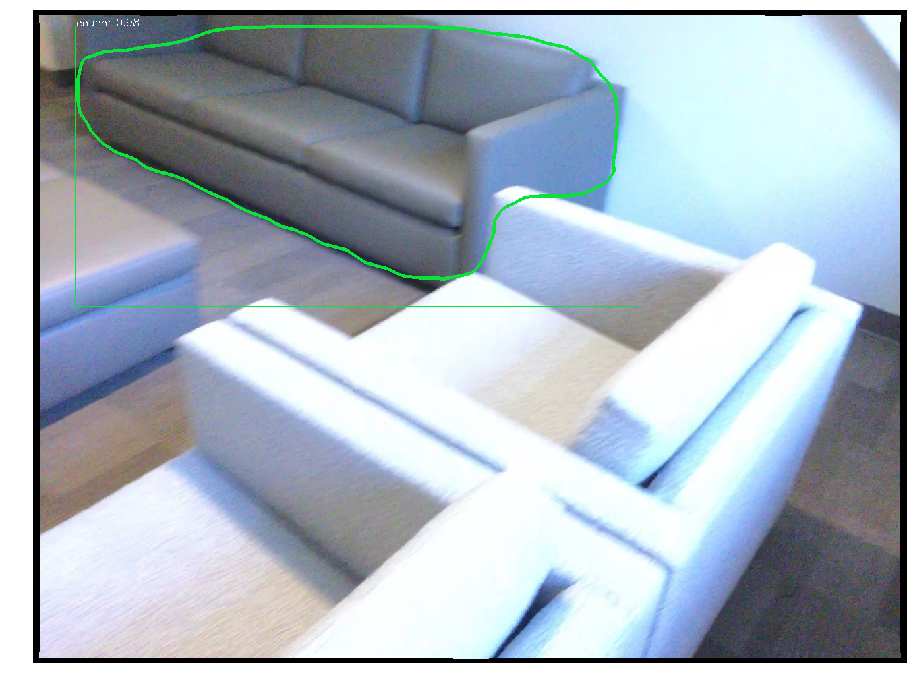

In [10]:
output_dir = '/home/wzhou14fall/output'    
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# xxx = {}
# xxx[''] = yyy
# with open('.json', 'w') as fp:
#     json.dump(xxx, fp)

info = {}


scenes = os.listdir(asset_dir)
# print(scenes)

for scene in scenes:
#     if scene.startswith("scene"):
    if scene == scene_id:
        scene_dir = os.path.join(asset_dir, scene)
        scene_output_dir = os.path.join(output_dir, scene)
        if not os.path.isdir(scene_output_dir):
            os.mkdir(scene_output_dir)
#         print(scene_dir)

        for file in os.listdir(scene_dir):
            if file.endswith(".jpg"):
                img_fn_dir = os.path.join(scene_dir, file)
                pil_image = Image.open(img_fn_dir).convert("RGB")
                image = np.array(pil_image)[:, :, [2, 1, 0]]
#                 imshow(image)

                predictions, features, top_predictions = coco_demo.run_on_opencv_image(image)
    
                masks = top_predictions.get_field("mask").numpy()
                masks = np.squeeze(masks, axis=1)
                scores = top_predictions.get_field("scores").tolist()
            
            
                labels = top_predictions.get_field("labels").tolist()
                labels = [coco_demo.CATEGORIES[i] for i in labels]
                
                imshow(predictions)
                print(len(masks))
                print(masks.shape)
                print(masks)
                print(scores)
                print(labels)
                for feature in features:
                    print(feature.size())
#                     print(feature)

                torch.save(features, str(scene_output_dir)+'/'+str(file)+'.pt')


#                 break
                
#         break
        
    


In [ ]:

img_filenames = os.listdir(img_dir)
# print(files)

for img_fn in img_filenames:
    img_fn_dir = os.path.join(img_dir, img_fn)
    pil_image = Image.open(img_fn_dir).convert("RGB")
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    imshow(image)
    
    predictions, features = coco_demo.run_on_opencv_image(image)
    imshow(predictions)
    for feature in features:
        print(feature.size())
        
    torch.save(features, str(output_dir)+str(img_fn)+'.pt')
        
        
    break





In [ ]:
loaded_features = torch.load(str(output_dir)+str(img_fn)+'.pt')
print(len(loaded_features))
for feature in features:
        print(feature.size())
print(loaded_features)